# 📊 VBT Window Analysis

Analyze all saved VBT event windows from `csv_shots/` folder.

- Visualize magnitude curves with markers
- Display VBT metrics (MV, PV, MPV, Power)
- Compare valid vs rejected patterns

## 📦 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 🔍 Load CSV Files

In [2]:
csv_folder = Path('csv_shots')
csv_files = sorted(csv_folder.glob('*.csv'))

print(f"Found {len(csv_files)} window CSV files:\n")
for i, f in enumerate(csv_files, 1):
    print(f"   {i}. {f.name}")

Found 6 window CSV files:

   1. window_20251120_121007_VALID.csv
   2. window_20251120_121014_VALID.csv
   3. window_20251120_121022_VALID.csv
   4. window_20251120_121031_REJECTED.csv
   5. window_20251120_121039_VALID.csv
   6. window_20251120_121047_VALID.csv


## 📖 Parse CSV Function

In [3]:
def parse_vbt_csv(filepath):
    """Parse VBT window CSV file with metadata, metrics, markers, and time series"""
    
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    data = {
        'metadata': {},
        'metrics': {},
        'markers': [],
        'timeseries': None
    }
    
    section = None
    
    for i, line in enumerate(lines):
        line = line.strip()
        
        if not line:
            continue
        
        # Detect sections
        if line.startswith('# VBT Window Data Export'):
            section = 'metadata'
            continue
        elif line.startswith('# VBT METRICS'):
            section = 'metrics'
            continue
        elif line.startswith('# MARKERS'):
            section = 'markers'
            continue
        elif line.startswith('# TIME SERIES DATA'):
            section = 'timeseries'
            # Read remaining lines as DataFrame
            df = pd.read_csv(filepath, skiprows=i+1)
            data['timeseries'] = df
            break
        
        # Skip other comment lines
        if line.startswith('#'):
            parts = line[1:].split(',', 1)
            if len(parts) == 2:
                key = parts[0].strip()
                value = parts[1].strip()
                data['metadata'][key] = value
            continue
        
        # Parse data based on section
        if section == 'metrics':
            parts = line.split(',')
            if len(parts) >= 2:
                metric_name = parts[0].strip()
                metric_value = parts[1].strip()
                unit = parts[2].strip() if len(parts) > 2 else ''
                data['metrics'][metric_name] = {'value': metric_value, 'unit': unit}
        
        elif section == 'markers':
            parts = line.split(',')
            if len(parts) >= 3 and parts[0] != 'Marker':
                marker = {
                    'name': parts[0].strip(),
                    'time': float(parts[1].strip()),
                    'magnitude': float(parts[2].strip()),
                    'color': parts[3].strip() if len(parts) > 3 else 'gray'
                }
                data['markers'].append(marker)
    
    return data

## 📈 Visualization Function

In [4]:
def plot_vbt_window(data, title=None):
    """Plot VBT window with markers and metrics"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # === LEFT: Magnitude plot ===
    df = data['timeseries']
    metadata = data['metadata']
    markers = data['markers']
    metrics = data['metrics']
    
    # Plot magnitude
    ax1.plot(df['Time_Relative (s)'], df['Magnitude (g)'], 
             'purple', linewidth=2.5, alpha=0.8, label='Magnitude')
    
    # Baseline and thresholds
    baseline = float(metadata.get('Baseline (g)', 1.0))
    min_depth = float(metadata.get('Min Depth Threshold (g)', 0.6))
    min_peak = float(metadata.get('Min Peak Threshold (g)', 1.05))
    
    ax1.axhline(y=baseline, color='blue', linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Baseline ({baseline:.3f}g)')
    ax1.axhline(y=min_depth, color='orange', linestyle='--', linewidth=1, 
                alpha=0.5, label=f'Min Depth ({min_depth:.2f}g)')
    ax1.axhline(y=min_peak, color='cyan', linestyle='--', linewidth=1, 
                alpha=0.5, label=f'Min Peak ({min_peak:.2f}g)')
    
    # Plot markers
    for m in markers:
        ax1.scatter([m['time']], [m['magnitude']], s=300, marker='o', 
                   color=m['color'], edgecolors='black', linewidths=2.5, 
                   zorder=10, label=m['name'].replace('_', ' ').title())
        ax1.annotate(f"{m['magnitude']:.3f}g", 
                    xy=(m['time'], m['magnitude']), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor=m['color'], 
                             alpha=0.7, edgecolor='black', linewidth=1.5))
    
    # Styling
    status = metadata.get('Status', 'UNKNOWN')
    timestamp = metadata.get('Timestamp', 'N/A')
    load = metadata.get('Load Weight (kg)', '0')
    
    ax1.set_title(f"Event Window - {status}\n{timestamp} | Load: {load} kg", 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Magnitude (g)', fontsize=12)
    ax1.set_ylim(0, df['Magnitude (g)'].max() * 1.1)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=9, framealpha=0.9)
    
    # === RIGHT: Metrics table ===
    ax2.axis('off')
    
    if metrics:
        table_data = []
        table_data.append(['Metric', 'Value', 'Unit'])
        table_data.append(['='*30, '='*15, '='*10])
        
        for metric_name, metric_info in metrics.items():
            table_data.append([metric_name, metric_info['value'], metric_info['unit']])
        
        table = ax2.table(cellText=table_data, loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2.5)
        
        # Header styling
        for i in range(3):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        ax2.set_title('VBT Metrics', fontsize=14, fontweight='bold', pad=20)
    else:
        ax2.text(0.5, 0.5, 'No VBT metrics\n(Pattern REJECTED)', 
                ha='center', va='center', fontsize=16, color='red', 
                fontweight='bold', transform=ax2.transAxes)
    
    plt.tight_layout()
    return fig

## 🎨 Analyze All Windows


Analyzing: window_20251120_121007_VALID.csv


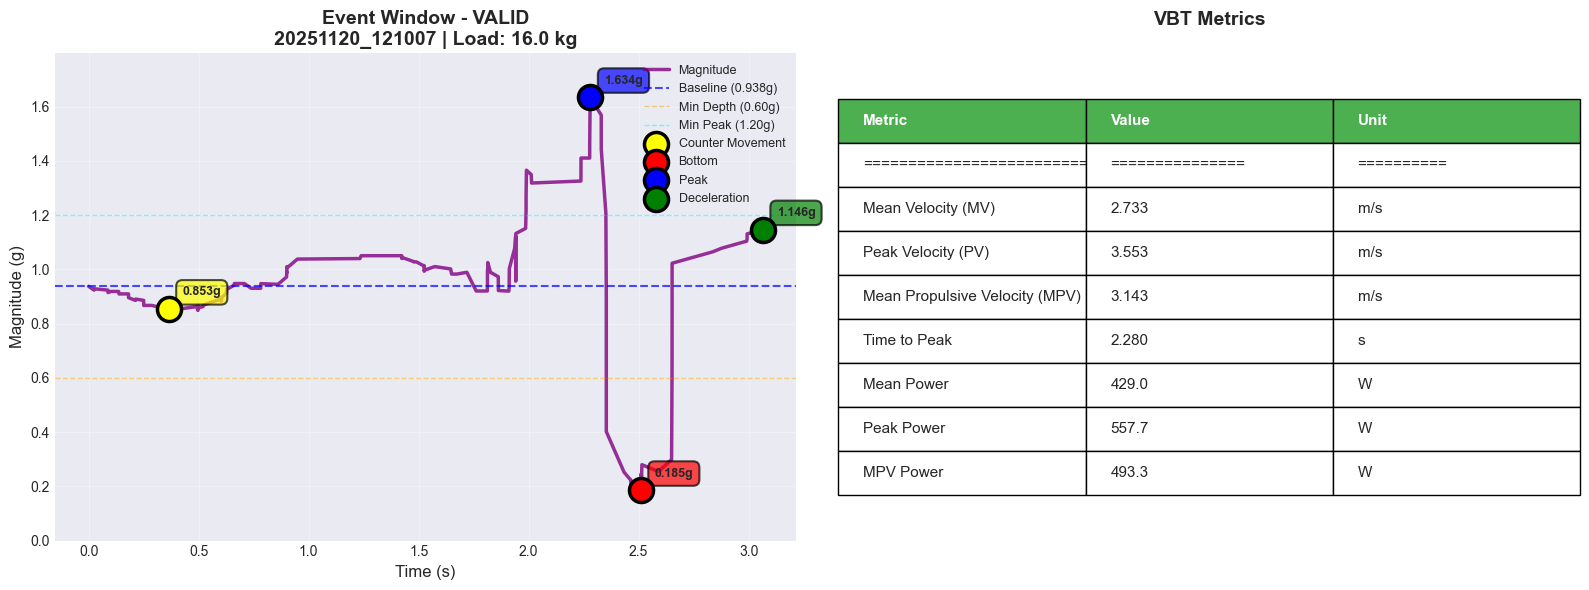


📊 Summary:
   Status: VALID
   Load: 16.0 kg
   Markers: 4
   Samples: 133

   Key Metrics:
      Mean Velocity (MV): 2.733 m/s
      Peak Velocity (PV): 3.553 m/s
      Mean Propulsive Velocity (MPV): 3.143 m/s
      Time to Peak: 2.280 s
      Mean Power: 429.0 W
      Peak Power: 557.7 W
      MPV Power: 493.3 W

Analyzing: window_20251120_121014_VALID.csv


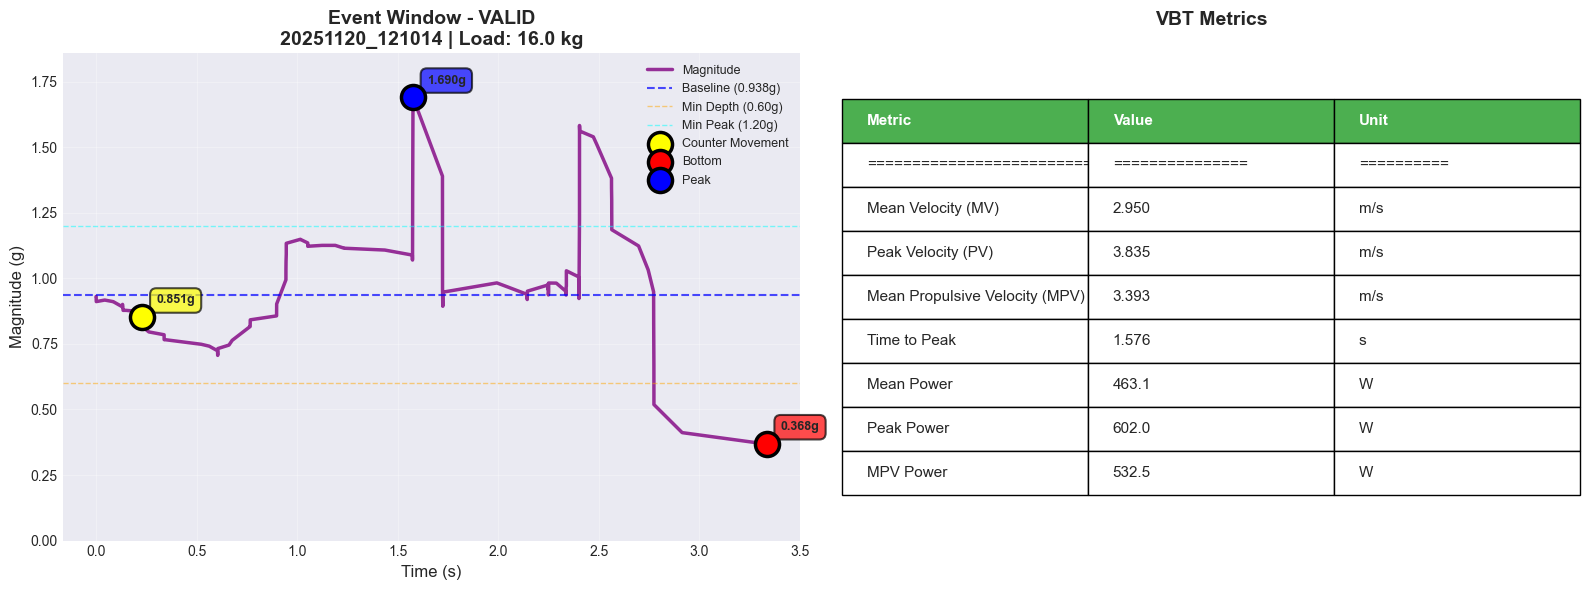


📊 Summary:
   Status: VALID
   Load: 16.0 kg
   Markers: 3
   Samples: 104

   Key Metrics:
      Mean Velocity (MV): 2.950 m/s
      Peak Velocity (PV): 3.835 m/s
      Mean Propulsive Velocity (MPV): 3.393 m/s
      Time to Peak: 1.576 s
      Mean Power: 463.1 W
      Peak Power: 602.0 W
      MPV Power: 532.5 W

Analyzing: window_20251120_121022_VALID.csv


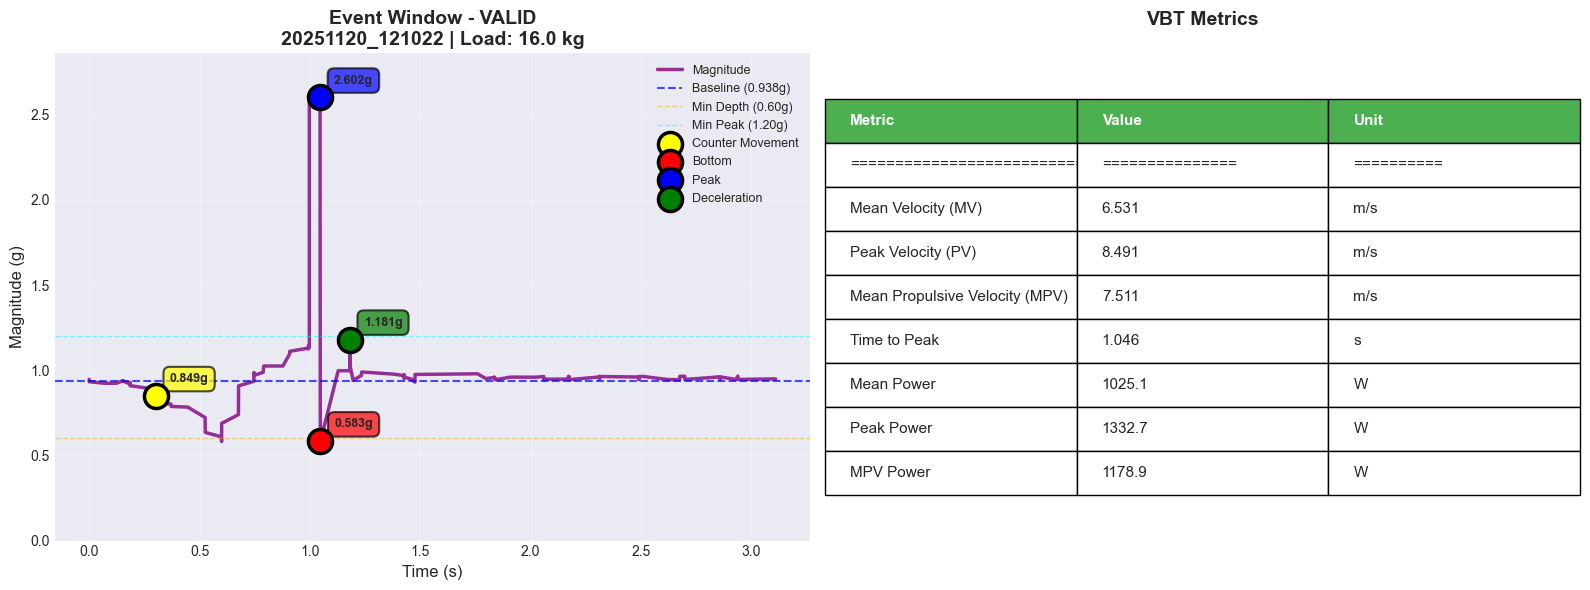


📊 Summary:
   Status: VALID
   Load: 16.0 kg
   Markers: 4
   Samples: 138

   Key Metrics:
      Mean Velocity (MV): 6.531 m/s
      Peak Velocity (PV): 8.491 m/s
      Mean Propulsive Velocity (MPV): 7.511 m/s
      Time to Peak: 1.046 s
      Mean Power: 1025.1 W
      Peak Power: 1332.7 W
      MPV Power: 1178.9 W

Analyzing: window_20251120_121031_REJECTED.csv


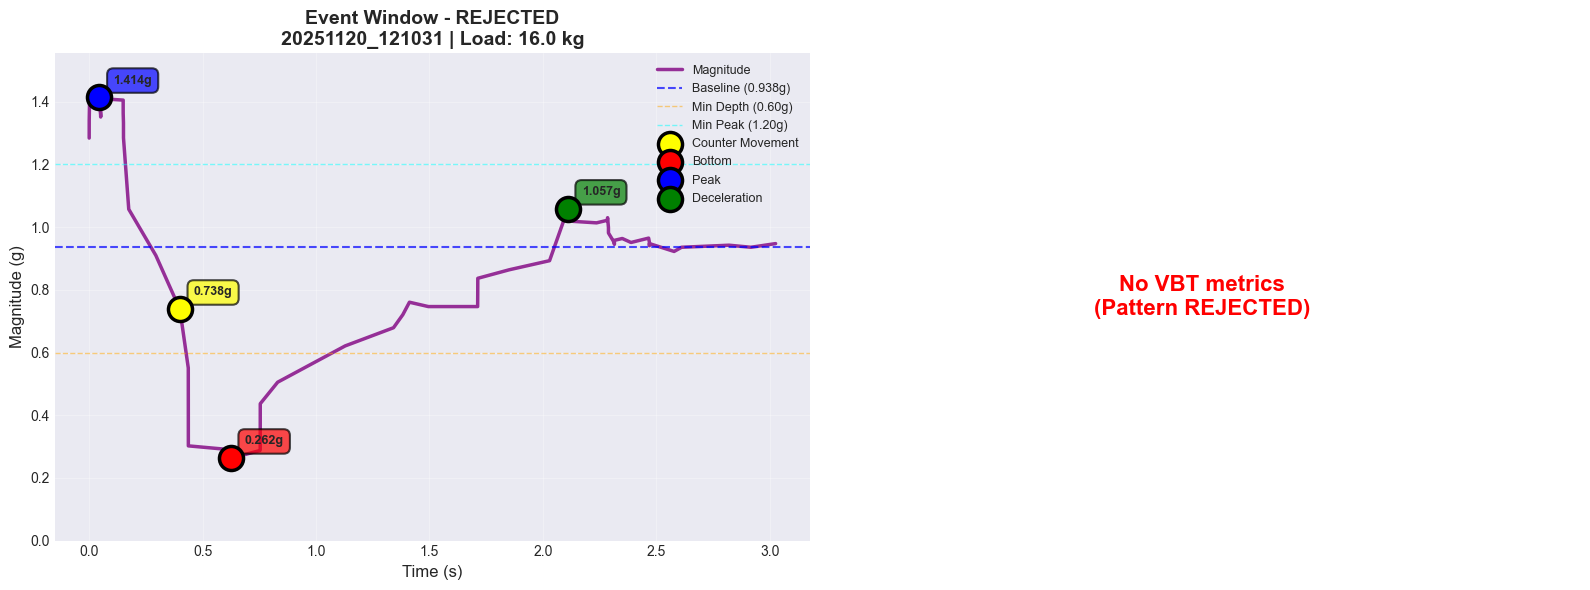


📊 Summary:
   Status: REJECTED
   Load: 16.0 kg
   Markers: 4
   Samples: 59

Analyzing: window_20251120_121039_VALID.csv


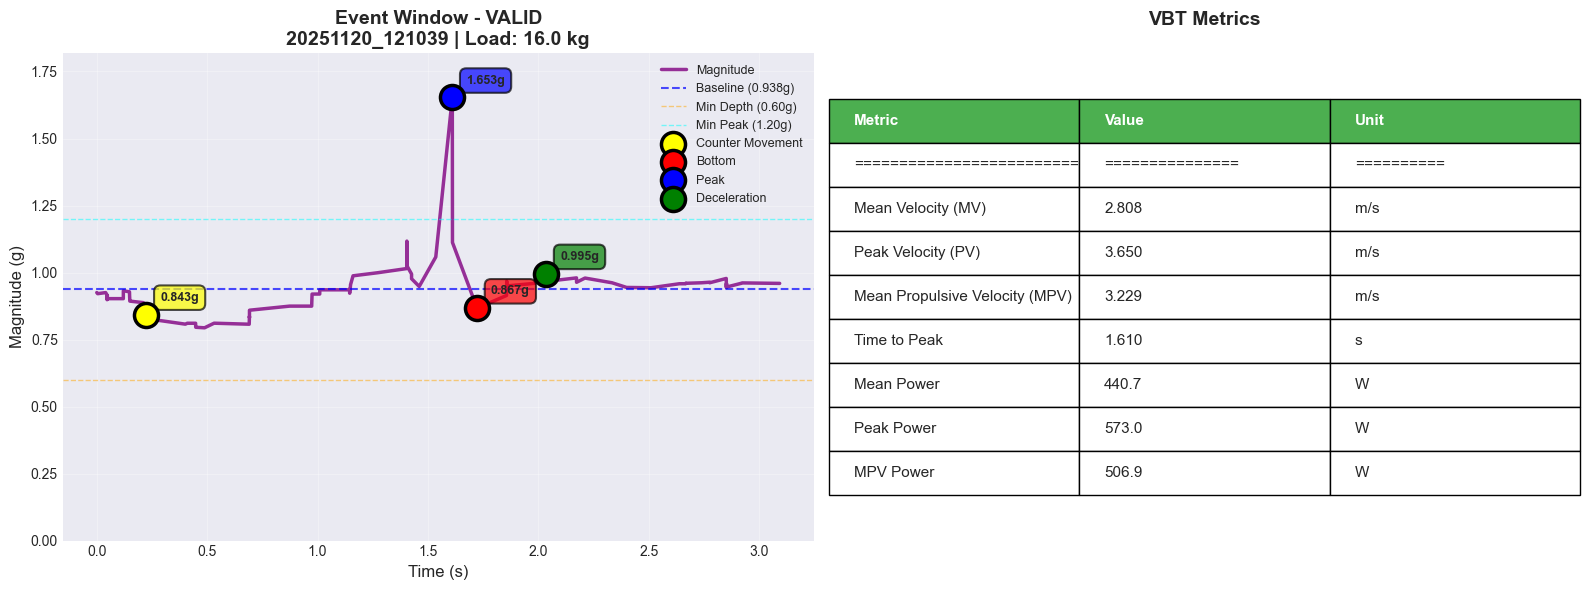


📊 Summary:
   Status: VALID
   Load: 16.0 kg
   Markers: 4
   Samples: 97

   Key Metrics:
      Mean Velocity (MV): 2.808 m/s
      Peak Velocity (PV): 3.650 m/s
      Mean Propulsive Velocity (MPV): 3.229 m/s
      Time to Peak: 1.610 s
      Mean Power: 440.7 W
      Peak Power: 573.0 W
      MPV Power: 506.9 W

Analyzing: window_20251120_121047_VALID.csv


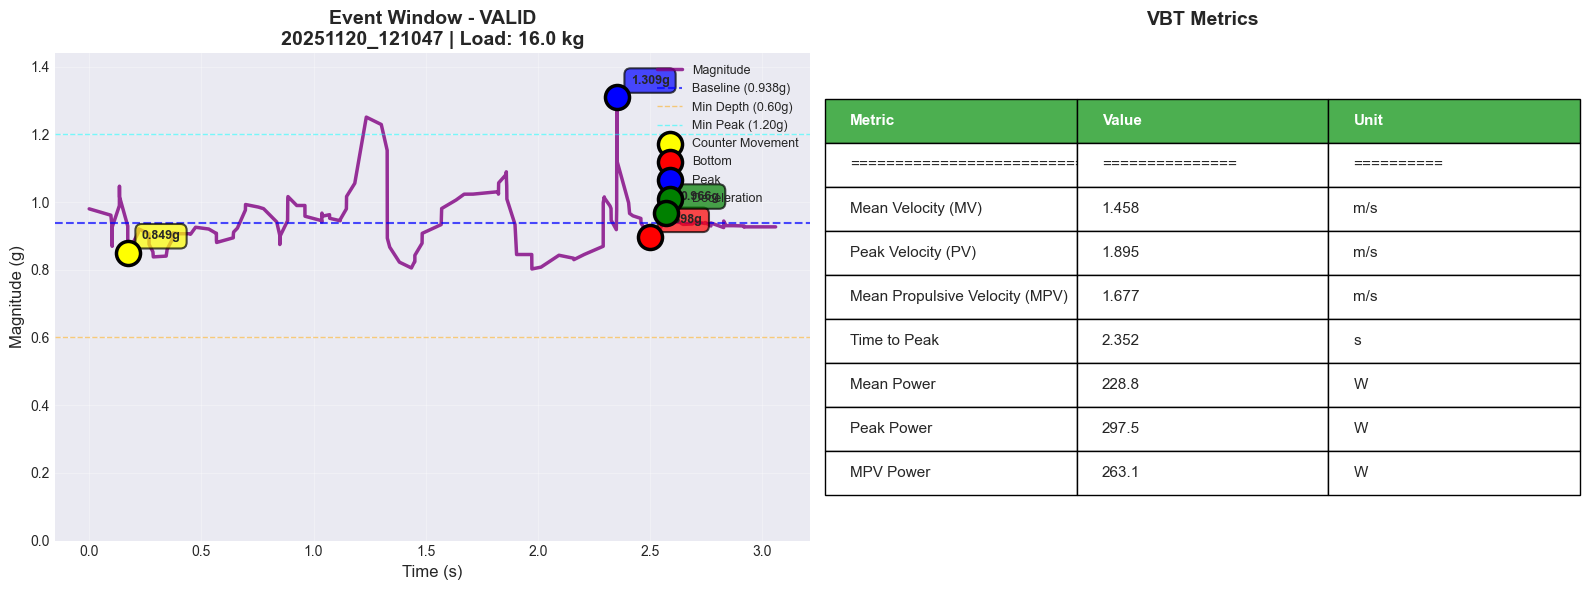


📊 Summary:
   Status: VALID
   Load: 16.0 kg
   Markers: 4
   Samples: 153

   Key Metrics:
      Mean Velocity (MV): 1.458 m/s
      Peak Velocity (PV): 1.895 m/s
      Mean Propulsive Velocity (MPV): 1.677 m/s
      Time to Peak: 2.352 s
      Mean Power: 228.8 W
      Peak Power: 297.5 W
      MPV Power: 263.1 W


In [5]:
for csv_file in csv_files:
    print(f"\n{'='*80}")
    print(f"Analyzing: {csv_file.name}")
    print(f"{'='*80}")
    
    try:
        data = parse_vbt_csv(csv_file)
        fig = plot_vbt_window(data, title=csv_file.stem)
        plt.show()
        
        # Print summary
        print(f"\n📊 Summary:")
        print(f"   Status: {data['metadata'].get('Status', 'N/A')}")
        print(f"   Load: {data['metadata'].get('Load Weight (kg)', '0')} kg")
        print(f"   Markers: {len(data['markers'])}")
        print(f"   Samples: {len(data['timeseries']) if data['timeseries'] is not None else 0}")
        
        if data['metrics']:
            print(f"\n   Key Metrics:")
            for k, v in data['metrics'].items():
                print(f"      {k}: {v['value']} {v['unit']}")
        
    except Exception as e:
        print(f"❌ Error processing {csv_file.name}: {e}")
        import traceback
        traceback.print_exc()

## 📊 Summary Statistics

In [6]:
# Collect all metrics from VALID windows
all_metrics = []

for csv_file in csv_files:
    try:
        data = parse_vbt_csv(csv_file)
        
        if data['metadata'].get('Status') == 'VALID' and data['metrics']:
            metrics_dict = {
                'filename': csv_file.name,
                'timestamp': data['metadata'].get('Timestamp', 'N/A'),
                'load_kg': float(data['metadata'].get('Load Weight (kg)', 0))
            }
            
            for metric_name, metric_info in data['metrics'].items():
                try:
                    metrics_dict[metric_name] = float(metric_info['value'])
                except:
                    metrics_dict[metric_name] = metric_info['value']
            
            all_metrics.append(metrics_dict)
    except:
        pass

if all_metrics:
    df_summary = pd.DataFrame(all_metrics)
    print("\n" + "="*80)
    print("SUMMARY STATISTICS (Valid Windows Only)")
    print("="*80 + "\n")
    print(df_summary.describe())
    
    # Velocity loss calculation (if multiple reps)
    if len(df_summary) >= 2 and 'Mean Velocity (MV)' in df_summary.columns:
        first_mv = df_summary['Mean Velocity (MV)'].iloc[0]
        last_mv = df_summary['Mean Velocity (MV)'].iloc[-1]
        vl_percent = ((first_mv - last_mv) / first_mv) * 100
        
        print(f"\n📉 Velocity Loss Analysis:")
        print(f"   First Rep MV: {first_mv:.3f} m/s")
        print(f"   Last Rep MV:  {last_mv:.3f} m/s")
        print(f"   Velocity Loss: {vl_percent:.1f}%")
        
        if vl_percent > 20:
            print("   ⚠️  HIGH fatigue - consider stopping set")
        elif vl_percent > 10:
            print("   ⚡ Moderate fatigue - good training stimulus")
        else:
            print("   ✅ Low fatigue - maintaining velocity")
else:
    print("\n⚠️  No valid windows found for summary statistics")


SUMMARY STATISTICS (Valid Windows Only)

       load_kg  Mean Velocity (MV)  Peak Velocity (PV)  \
count      5.0            5.000000            5.000000   
mean      16.0            3.296000            4.284800   
std        0.0            1.905144            2.477099   
min       16.0            1.458000            1.895000   
25%       16.0            2.733000            3.553000   
50%       16.0            2.808000            3.650000   
75%       16.0            2.950000            3.835000   
max       16.0            6.531000            8.491000   

       Mean Propulsive Velocity (MPV)  Time to Peak   Mean Power   Peak Power  \
count                        5.000000      5.000000     5.000000     5.000000   
mean                         3.790600      1.772800   517.340000   672.580000   
std                          2.190979      0.544563   299.038113   388.760385   
min                          1.677000      1.046000   228.800000   297.500000   
25%                          3

## 📈 Velocity Trend Plot

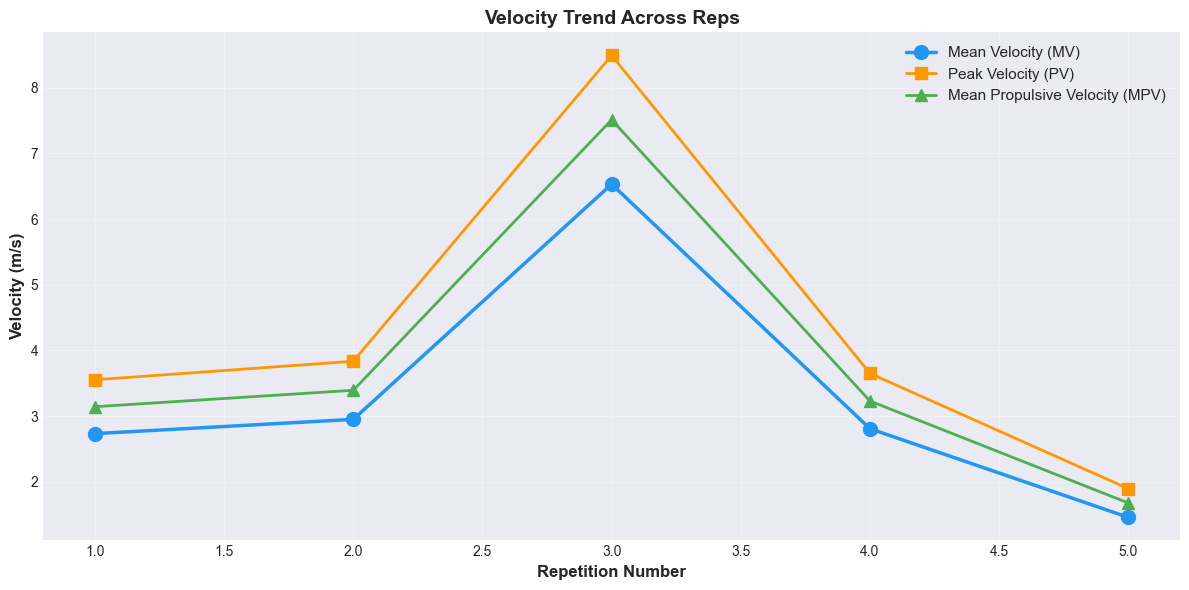

In [7]:
if all_metrics and len(all_metrics) >= 2:
    df_summary = pd.DataFrame(all_metrics)
    
    if 'Mean Velocity (MV)' in df_summary.columns:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        rep_numbers = range(1, len(df_summary) + 1)
        
        # Plot MV, PV, MPV
        ax.plot(rep_numbers, df_summary['Mean Velocity (MV)'], 
               'o-', linewidth=2.5, markersize=10, label='Mean Velocity (MV)', color='#2196F3')
        
        if 'Peak Velocity (PV)' in df_summary.columns:
            ax.plot(rep_numbers, df_summary['Peak Velocity (PV)'], 
                   's-', linewidth=2, markersize=8, label='Peak Velocity (PV)', color='#FF9800')
        
        if 'Mean Propulsive Velocity (MPV)' in df_summary.columns:
            ax.plot(rep_numbers, df_summary['Mean Propulsive Velocity (MPV)'], 
                   '^-', linewidth=2, markersize=8, label='Mean Propulsive Velocity (MPV)', color='#4CAF50')
        
        ax.set_xlabel('Repetition Number', fontsize=12, fontweight='bold')
        ax.set_ylabel('Velocity (m/s)', fontsize=12, fontweight='bold')
        ax.set_title('Velocity Trend Across Reps', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11)
        
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠️  Not enough data for velocity trend plot (need ≥2 valid reps)")